In [1]:
!pip install -Uqq fastbook
!pip list -v | grep fastai

     |████████████████████████████████| 727kB 8.6MB/s 
     |████████████████████████████████| 194kB 18.2MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 1.1MB 24.2MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
fastai                        2.1.9           /usr/local/lib/python3.6/dist-packages pip      


In [2]:
from PIL import ImageFile

import pandas as pd
import re

from pathlib import Path
from datetime import datetime

from fastbook import *
from fastai import * 
from fastai.vision.widgets import *
from fastai.callback.fp16 import *

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Mount Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## Raw data

In [6]:
path = Path('/content/drive/MyDrive/MACHINLEARNING/DesafioAgTech2020/data/train_ts_fullbandas_conX')
test = Path('/content/drive/MyDrive/MACHINLEARNING/DesafioAgTech2020/data/test_ts_fullbandas_conX')

In [7]:
path.exists()

True

In [8]:
etiquetas_url = 'https://raw.githubusercontent.com/DesafiosAgTech/DesafioAgTech2020/master/dataset/Etiquetas.csv'
etiquetas =  pd.read_csv(etiquetas_url, error_bad_lines=False)

## Parameters

Parameters de arquitectura y de training

In [9]:
model_id = "xresnet50_timeseries_fullbandas_conX_weightCross"

In [10]:
# instantiate balanced accuracy metric
balanced_accuracy = BalancedAccuracy()

# dataloader
seed = 1 # seed split train-validation
valid_pct = 0.2 # % data validacion
bs = 32 # batch size

# fine_tune model parameters
arch =  xresnet50  # architecture
loss_func = CrossEntropyLossFlat
pretrained = True
metrics = [balanced_accuracy, error_rate]
epochs = 10
lr = 10e-3
# opt_func = Adam (valor default)

## Data

In [11]:
# Load data with fastai
lotes2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=valid_pct, seed=seed),
    get_y=parent_label,
    item_tfms=RatioResize(224))
# square of resize pixels. Bigger the better but more hardware needed pg28 of fastai

dls = lotes2.dataloaders(path, bs = bs)

Controles

In [12]:
# N of training data
dls.train.n

680

In [13]:
dls.train.vocab

['A', 'B', 'G', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'X', 'aa', 'm', 's']

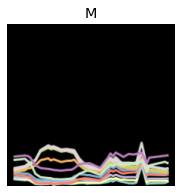

In [15]:
dls.valid.show_batch(max_n=1, nrows=1)

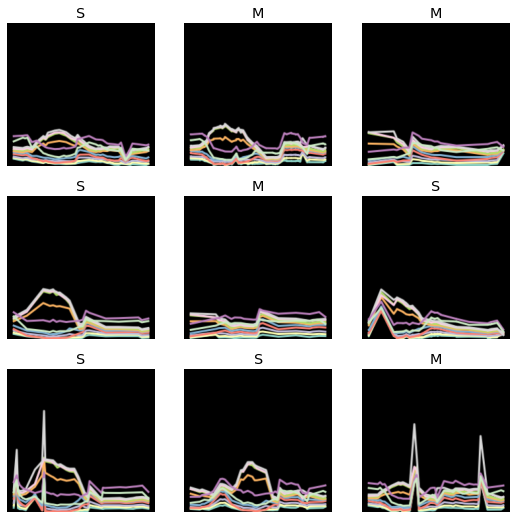

In [16]:
dls.show_batch()

## Sample weights

In [17]:
def make_weights_for_balanced_classes(labels , nclasses):
  """
  Returns weight of each image 
  Weights are inversely correlated to class frequency 
  """
  count = [0] * nclasses                                                      
  for l in labels:                                                         
      count[l] += 1                                                     
  weight_per_class = [0.] * nclasses                                      
  N = float(sum(count))                                                   
  for i in range(nclasses):                                                   
      weight_per_class[i] = N/float(count[i])                                 
  weight = [0] * len(labels)                                              
  for idx, val in enumerate(labels):                                          
      weight[idx] = weight_per_class[val]                                  
  return weight


def get_sampler(dataloader):
  """
  Returns sampler using weights for a given data
  Esta funcion es una alternativa a get_weights()
  """
  imagenes = list()
  labels = list()
  for i,l in dataloader.train:
    imagenes.append(i)
    labels.append(l)
  imagenes2 = torch.cat(imagenes)
  labels2 = torch.cat(labels)
  n_classes = len(torch.unique(labels2))
  weights = make_weights_for_balanced_classes(labels2, n_classes)                                                                
  weights = torch.DoubleTensor(weights)                                       
  sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
  return sampler


def get_weights(dls):
  """
  Get weights based on the class distribution in the training data
  Basado en https://forums.fast.ai/t/oversampling-in-fastai2/73721/3
  Esta funcion es una alternativa a get_sampler()
  """
  # 0th index would provide the vocab from text
  # 1st index would provide the vocab from classes
  classes = dls.train.vocab
  #Get label ids from the dataset using map
  #train_lb_ids = L(map(lambda x: x[1], dls.train_ds))
  # Get the actual labels from the label_ids & the vocab
  #train_lbls = L(map(lambda x: classes[x], train_lb_ids))
  #Combine the above into a single
  train_lbls = L(map(lambda x: classes[x[1]], dls.train_ds))
  label_counter = Counter(train_lbls)
  n_most_common_class = max(label_counter.values()); 
  print(f'Occurrences of the most common class {n_most_common_class}')
  # Source: https://discuss.pytorch.org/t/what-is-the-weight-values-mean-in-torch-nn-crossentropyloss/11455/9
  # weights = [n_most_common_class/v for k, v in label_counter.items() if v > 0]; return weights 
  weights = [n_most_common_class/label_counter[k] for  k in dls.train.vocab ]
  return weights


In [18]:
weights = get_weights(dls) 
class_weights = torch.FloatTensor(weights).to(dls.device)

Occurrences of the most common class 263


In [19]:
class_weights

tensor([263.0000,  52.6000, 263.0000,   1.5115,   4.1746,   5.5957,  65.7500,   1.0000, 131.5000,  29.2222,   9.0690, 263.0000,  65.7500,   3.4156], device='cuda:0')

## Learning rate

Find "optimal" learning rate

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


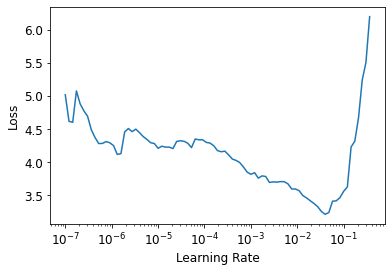

In [20]:
learn = None
learn = cnn_learner(
    dls, arch, loss_func=loss_func(weight=class_weights), pretrained=pretrained
    , metrics=metrics)
lr_min, lr_steep = learn.lr_find()
# # # 10e-3 - 10e-2

## Train - validate

epoch,train_loss,valid_loss,balanced_accuracy_score,error_rate,time
0,4.006904,4.528327,0.308096,0.887574,00:27


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


epoch,train_loss,valid_loss,balanced_accuracy_score,error_rate,time
0,3.191602,2.441882,0.461327,0.579882,00:07
1,2.088838,2.489820,0.352534,0.384615,00:07
2,1.889587,2.692203,0.351003,0.396450,00:07
3,1.988595,2.917469,0.366711,0.656805,00:07
4,1.860115,2.641690,0.491098,0.633136,00:07
5,1.853904,2.165504,0.318034,0.544379,00:07
6,1.533070,2.788285,0.478594,0.437870,00:07
7,1.251751,1.976319,0.627336,0.301775,00:07
8,0.967966,1.878318,0.625372,0.319527,00:07
9,0.792846,1.985862,0.623127,0.331361,00:07


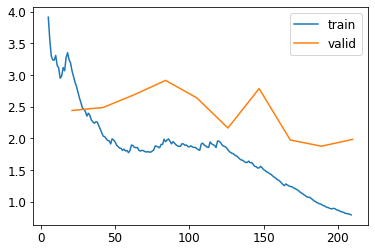

In [21]:
# def set_seeds():
#   random.seed(42)
#   np.random.seed(12345)
#   torch.manual_seed(1234)
#   torch.backends.cudnn.deterministic = True
#   torch.backends.cudnn.benchmark = False

# set_seeds()

learn = None
learn = cnn_learner(
    dls, arch, loss_func=loss_func(weight=class_weights), pretrained=pretrained
    , metrics= metrics).to_fp16()
learn.fine_tune(epochs=epochs, base_lr=lr)
learn.recorder.plot_loss()

### Performance

Validation metrics

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


[('S', 'M', 8), ('N', 'P', 6), ('S', 'X', 6), ('S', 's', 5)]

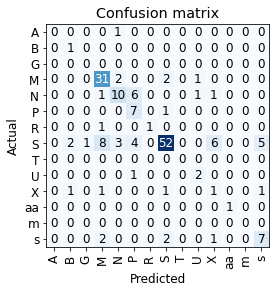

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused(min_val=5)

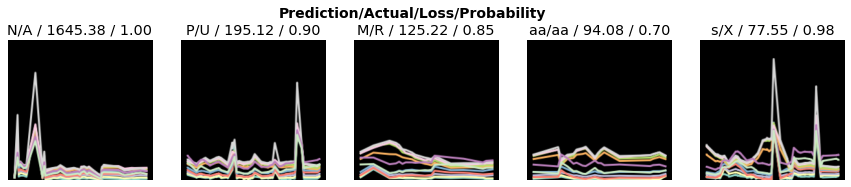

In [23]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
# # loss of each validation image
# interp.losses.abs()

## Train

Final training with all data (train + validation)

Occurrences of the most common class 344


epoch,train_loss,valid_loss,balanced_accuracy_score,error_rate,time
0,4.507708,None,None,None,00:06


/usr/local/lib/python3.6/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,balanced_accuracy_score,error_rate,time
0,2.727562,None,None,None,00:07
1,2.064790,None,None,None,00:07
2,1.912340,None,None,None,00:07
3,1.825613,None,None,None,00:07
4,1.759326,None,None,None,00:07
5,1.506893,None,None,None,00:07
6,1.198922,None,None,None,00:07
7,0.944646,None,None,None,00:07
8,0.744466,None,None,None,00:07
9,0.610351,None,None,None,00:07


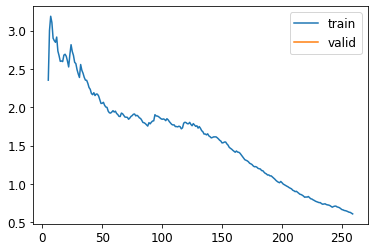

In [24]:
lotes_alldata = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.0, seed=seed),
    get_y=parent_label,
    item_tfms=RatioResize(224))

dls_alldata = lotes_alldata.dataloaders(path, bs=bs)

weights = get_weights(dls_alldata) 
class_weights = torch.FloatTensor(weights).to(dls_alldata.device)

learn = None
learn = cnn_learner(
    dls_alldata, arch, loss_func=loss_func(weight=class_weights)
    , pretrained=pretrained, metrics=metrics).to_fp16()
learn.fine_tune(epochs=epochs, base_lr=lr)
learn.recorder.plot_loss()

## Save

In [ ]:
model_file = f'/content/drive/MyDrive/MACHINLEARNING/DesafioAgTech2020/{model_id}.pkl'

# save models as pkl
learn.export(model_file)

In [ ]:
def generate_submit_from_learner(
    pkt_path_str
    ,test_path_str='/content/drive/MyDrive/MACHINLEARNING/DesafioAgTech2020/data/test'
    ,export_path_str = '/content/drive/MyDrive/MACHINLEARNING/DesafioAgTech2020/submit/'):
    """
    Submits csv ready to upload in the export path. Date at the end
    Input: 
      - pkl learner path as string
      - path of test directory (.png) as string. Must end in GlobalId.png
      - path to export directory as string
    """
    etiquetas_url = 'https://raw.githubusercontent.com/DesafiosAgTech/DesafioAgTech2020/master/dataset/Etiquetas.csv'
    etiquetas =  pd.read_csv(etiquetas_url, error_bad_lines=False)
    # Load model and predict using same transformation?
    learn = load_learner(str(pkt_path_str))
    test_dl = learn.dls.test_dl(get_image_files(test_path_str))
    # Predicts and returns most probable class
    preds,y = learn.get_preds(dl = test_dl)
    y = torch.argmax(preds, dim = 1)
    # Predicted to corresponding CultivoId + add global id for submit
    glob_list = [re.findall(r'(\d+).png', r) for r in [str(p) for p in test_dl.items]]
    globalids = [int(id) for sub in glob_list for id in sub] 
    prediction = [learn.dls.vocab[p] for p in y.tolist()]
    prediction_df = pd.DataFrame(zip(globalids,prediction), columns=['globalid','clase'])
    submit = prediction_df.merge(
        etiquetas, how="left", left_on='clase', right_on='Cultivo')[['globalid','CultivoId']]
    # exports submit
    now = datetime.now()
    file_name = \
      str(export_path_str) + now.strftime('%Y%m%d%H%M') + str(test_path_str).split("/")[-1] + '.csv'
    submit.to_csv(file_name, header=False, index=False)
    

In [ ]:
# submit csv of results
generate_submit_from_learner(model_file, test_path_str=str(test))